# Introduction to neural networks using Keras II

#### By Julian Rincon, _Department of Applied Mathematics and Computer Science, Universidad del Rosario_
#### Notebook originally written by Pavlos Protopapas, _Harvard Institute for Applied Computational Science_
###### Based on the book [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python) by François Chollet.

In this (second) part of the tutorial, we will explore fundamental aspects in machine learning such as 

1. how to evaluate models, 
2. overfitting, and 
3. underfitting.

We will go through some exercises to review those concepts.

---

## Fundamentals of Machine Learning

The `MNIST` example belongs to a category of machine learning called *supervised learning*. This is by far the most common case. It consists of learning to map out input data to known targets (also called *annotations*), given a set of examples (often annotated by humans).  Generally, almost all applications of deep learning that are in the spotlight these days belong in this category, such as optical character recognition, speech recognition, image classification, and language translation.

### Evaluating machine-learning models

In the `MNIST` example, we split the data into a training set and a test set. The reason not to evaluate the models on the same data they were trained on quickly became evident: after just a few epochs, the model began to *overfit*. That is, their performance on never-before-seen data started stalling (or worsening) compared to their performance on the training data, which always improves as training progresses.

In machine learning, the goal is to achieve models that *generalize*, that perform well on never-before-seen data, and overfitting is the central obstacle. You can only control that which you can observe, so it's crucial to be able to reliably measure the generalization power of your model. The following sections look at strategies for mitigating overfitting and maximizing generalization. In this section, we'll focus on how to measure generalization: how to evaluate machine-learning models.

At the end of the day, you'll end up with a model that performs artificially well on the training data, because that's what you optimized it for. You care about performance on completely new data, not the training data, so you need to use a completely different, never-before-seen dataset to evaluate the model: the test dataset. Your model shouldn't have had access to any information about the test set, even indirectly. If anything about the model has been tuned based on test set performance, then your measure of generalization will be flawed.

Splitting your data into training and test sets may seem straightforward, but there are a few advanced ways to do it that can come in handy when little data is available. Let's review three classic model evaluation recipes: simple hold-out validation, K-fold validation, and iterated K-fold validation with shuffling.

#### Simple Hold-out Validation

This is what we did with the `MNIST` data. Set apart some fraction of your data as your test set. Train on the remaining data, and evaluate on the test set. This is the simplest evaluation protocol, and it suffers from one flaw: if little data is available, then your training and test sets may contain too few samples to be statistically representative of the data at hand. This is easy to recognize: if different random shuffling rounds of the data before splitting end up yielding very different measures of model performance, then you're having this issue. K-fold validation and iterated K-fold validation are two ways to address this, as discussed next.

![hold out validation](holdout.png)

#### K-fold Validation

With this approach, you split your data into $K$ partitions of equal size. For each partition `i`, train a model on the remaining $K - 1$ partitions, and evaluate it on partition `i`. Your final score is then the averages of the $K$ scores obtained. This method is helpful when the performance of your model shows significant variance based on your train-test split. Like hold-out validation, this method doesn't exempt you from using a distinct validation set for model calibration.

![K-fold validation](kfold.png)

#### Iterated K-Fold Validation with Shuffling

This validation method is for situations in which you have relatively little data available and you need to evaluate your model as precisely as possible. This can be helpful in [Kaggle](https://www.kaggle.com/) competitions. It consists of applying K-fold validation multiple times, shuffling the data every time before splitting it $K$ ways. The final score is the average of the scores obtained at each run of K-fold validation. Note that you end up training and evaluating $P \times K$ models (where $P$ is the number of iterations you use), which can very expensive and time-consuming.

### Overfitting and Underfitting

In the `MNIST` case, the performance of the model on the hold-out validation data always peaked after a few epochs and then began to degrade: the model quickly started to overfit to the training data. Overfitting happens in every machine-learning problem. Learning how to deal with overfitting is essential to mastering machine learning.
**_The fundamental issue in machine learning is the tension between optimization and generalization._** *Optimization* refers to the process of adjusting a model to get the best performance possible on the training data (the *learning* in *machine learning*), whereas *generalization* refers to how well the trained model performs on data it has never seen before. The goal of the game is to get good generalization, of course, but you don't control generalization; you can only adjust the model based on its training data.

At the beginning of training, optimization and generalization are correlated: the lower the loss on training data, the lower the loss on test data. While this is happening, your model is said to be *underfit*: there is still progress to be made; the network hasn't yet modeled all relevant patterns in the training data. But after a certain number of iterations on the training data, generalization stops improving, and validation metrics stall and then begin to degrade: the model is starting to overfit. That is, it's beginning to learn patterns that are specific to the training data but that are misleading or irrelevant when it comes to new data.

To prevent a model from learning misleading or irrelevant patterns found in the training data, *the best solution is to get more training data*. A model trained on more data will naturally generalize better. When that isn't possible, the next-best solution is to modulate the quantity of information that your model is allowed to store or to add constraints on what information it's allowed to store. If a network can only afford to memorize a small number of patterns, the optimization process will force it to focus on the most prominent patterns, which have a better chance of generalizing well. The processing of fighting overfitting this way is called *regularization*.

---

## Examples of model evaluation using the `MNIST` data

In this section we will apply two variants of model evaluation to the hand-written digit image classification problem. Can you spot what type they are? As part of the exercises, you will analyze the main differences, pros and cons, of the both evaluation methods.

The code in the following example is partially completed, part of your work will be to appropriately complete the code in order to complete the subsequent exercises.

### Code setup

We start importing and reading Keras, libraries for post-processing and analyzing the results, and the `MNIST` data. The coding workflow is very similar to what we did in the previous tutorial.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras import models
from keras import layers
from keras.datasets import mnist
from keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

Using TensorFlow backend.


#### Auxiliary functions

We now define a couple of methods: one for training iteratively, given training and validation data, and another one for preprocessing the input images and their corresponding labels.

In [2]:
def Train(training_data, training_labels, validation_data, validation_labels):
    """Insert docstring here..."""
    network = models.Sequential()
    network.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
    network.add(layers.Dense(10, activation='softmax'))

    network.compile(optimizer='rmsprop', loss='categorical_crossentropy',
                    metrics=['accuracy'])

    network.fit(training_data, training_labels, epochs=5, batch_size=128)

    training_score = network.evaluate(training_data, training_labels)
    validation_score = network.evaluate(validation_data, validation_labels)
    
    return validation_score, training_score

In [3]:
def Prepare(imgs, labs):
    """Insert docstring here..."""
    p_imgs = imgs.reshape((len(imgs), 28 * 28))
    p_imgs = p_imgs.astype('float32') / 255
    p_labs = to_categorical(labs)
    
    return p_imgs, p_labs

### Model evaluation

The next snippet of code performs k-fold validation, as discussed at the beginning of this tutorial.

In [4]:
k = 5
split = len(train_images) // k
print('split', split)
val_scores, tra_scores = [], []

for fold in range(k):
    print('*'*40, 'fold', fold, '*'*40)
    beg, end = fold * split, (fold + 1) * split    
    #print(beg, end)
    validation_data = train_images[beg:end, :, :]
    training_data = np.concatenate((train_images[:beg, :, :], train_images[end:, :, :]))
    
    validation_labels = train_labels[beg:end]
    training_labels = np.concatenate((train_labels[:beg], train_labels[end:]))
    #print(validation_labels.shape, training_labels.shape)
    
    tra_data, tra_lab = Prepare(training_data, training_labels)
    val_data, val_lab = Prepare(validation_data, validation_labels)
    
    val_score, tra_score = Train(tra_data, tra_lab, val_data, val_lab)
    val_scores.append(val_score)
    tra_scores.append(tra_score)

split 12000
**************************************** fold 0 ****************************************
Epoch 1/5
48000/48000 [==============================] - 8s 158us/step - loss: 0.2931 - acc: 0.9134
Epoch 2/5
48000/48000 [==============================] - 6s 132us/step - loss: 0.1200 - acc: 0.9649
Epoch 3/5
48000/48000 [==============================] - 6s 134us/step - loss: 0.0779 - acc: 0.9767
Epoch 4/5
48000/48000 [==============================] - 6s 135us/step - loss: 0.0561 - acc: 0.9827
Epoch 5/5
12000/12000 [==============================] - 1s 76us/step
**************************************** fold 1 ****************************************
Epoch 1/5
48000/48000 [==============================] - 7s 140us/step - loss: 0.2784 - acc: 0.9191
Epoch 2/5
48000/48000 [==============================] - 7s 137us/step - loss: 0.1164 - acc: 0.9656
Epoch 3/5
48000/48000 [==============================] - 6s 133us/step - loss: 0.0771 - acc: 0.9768
Epoch 4/5
48000/48000 [=================

Once the model is trained using the evaluation method, we proceed to analyze its performance using the information collected from each folding. We calculate the average accuracy of the model on both the training and validation datasets.

In [5]:
avg_tra_score = np.average(tra_scores, axis=0)
print('tra_scores', tra_scores, '\navg_tra_score', avg_tra_score)

avg_val_score = np.average(val_scores, axis=0)
print('val_scores', val_scores, '\navg_val_score', avg_val_score)

tra_scores [[0.027321261154681753, 0.9926041666666666], [0.02595657061651582, 0.9934166666666666], [0.02417182205582503, 0.9934583333333333], [0.028887729107150033, 0.9922291666666667], [0.027149055822907636, 0.9928333333333333]] 
avg_tra_score [0.02669729 0.99290833]
val_scores [[0.07893304079708954, 0.9770833333333333], [0.07949822312081233, 0.9760833333333333], [0.07956493813327203, 0.9774166666666667], [0.0961822855261465, 0.97225], [0.08196123723002771, 0.9765]] 
avg_val_score [0.08322794 0.97586667]


Next, we plot training and validation accuracies for better visualization of the results.

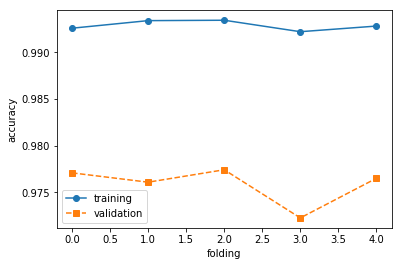

In [6]:
plt.plot(np.array(tra_scores)[:,1], '-o', label='training')
plt.plot(np.array(val_scores)[:,1], '--s', label='validation')
plt.ylabel('accuracy')
plt.xlabel('folding')
plt.legend()

What can you say about the optimization and generalization of the model based on the evaluation model we just performed?

#### Another method of model validation

[Keras](https://keras.io/)' method `fit` accepts a variety of arguments. For more details follow this [link](https://keras.io/models/sequential/). One of such arguments is `validation_split`, which is another way of performing model evaluation using validation data.

Let's start preparing the original data read from Keras first.

In [7]:
train_data, train_lab = Prepare(train_images, train_labels)
#test_data, test_lab = Prepare(test_images, test_labels)

The argument `validation_split` is defined as follows:

> **validation_split**: Float between 0 and 1. Fraction of the training data to be used as validation data. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch. The validation data is selected from the last samples in the x and y data provided, before shuffling.

Complete, run, analyze the results of the model using the following snippet of code. You should already be familiar with the instructions.

In [8]:
network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
network.add(layers.Dense(10, activation='softmax'))

network.compile(optimizer='rmsprop', loss='categorical_crossentropy',
                metrics=['accuracy'])

r = network.fit(train_data, train_lab, validation_split=0.333333, 
                epochs=5, batch_size=128)

train_loss, train_acc = network.evaluate(train_data, train_lab)
#test_loss, test_acc = network.evaluate(test_data, test_lab)

Train on 40000 samples, validate on 20000 samples
Epoch 1/5
40000/40000 [==============================] - 6s 142us/step - loss: 0.3116 - acc: 0.9110 - val_loss: 0.1765 - val_acc: 0.9480
Epoch 2/5
40000/40000 [==============================] - 6s 145us/step - loss: 0.1291 - acc: 0.9622 - val_loss: 0.1231 - val_acc: 0.9641
Epoch 3/5
40000/40000 [==============================] - 4s 105us/step - loss: 0.0841 - acc: 0.9751 - val_loss: 0.1131 - val_acc: 0.9671
Epoch 4/5
40000/40000 [==============================] - 4s 110us/step - loss: 0.0594 - acc: 0.9824 - val_loss: 0.0949 - val_acc: 0.9717
Epoch 5/5
60000/60000 [==============================] - 4s 63us/step


Once the model is trained using the argument `validation_split`, we proceed to analyze its performance using the information collected from the training. We calculate the average accuracy of the model on both the training and validation datasets.

In [9]:
r_acc = r.history['acc']
v_acc = r.history['val_acc']

Next, we plot training and validation accuracies for better visualization of the results.

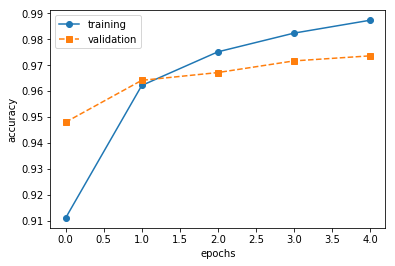

In [10]:
plt.plot(r_acc, marker='o', label='training')
plt.plot(v_acc, marker='s', linestyle='--', label='validation')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()

What can you say about the optimization and generalization of the model based on the evaluation model we just performed?

---

### Exercises

* Evaluate and plot the accuracy of the model on the test data for both approaches.
* Analyze and explain the main differences between the two machine-learning-model evaluation methods.
* Evaluate the `MNIST` example using now Iterated K-Fold Validation with Shuffling.
* Compare your results to what was obtained using K-Fold Validation. Discuss the differences.

---

## Pseudocode for _simple hold-out_ and _k-fold validation_

In this section we show pseudocode for both simple hold-out and k-fold validation methods. This can be useful when going through this tutorial.

### Hold-out validation

    num_validation_samples = 10000
    np.random.shuffle(data)
    
    validation_data = data[:num_validation_samples]
    data = data[num_validation_samples:]
    
    training_data = data[:]
    
    model = get_model()
    model.train(training_data)
    validation_score = model.evaluate(validation_data)
    
    # At this point you can tune your model,
    # retrain it, evaluate it, tune it again...
    
    model = get_model()
    model.train(np.concatenate([training_data, validation_data]))
    test_score = model.evaluate(test_data)

### K-fold validation

    k = 4
    num_val_sam = len(data) // k
    
    np.random.shuffle(data)
    validation_scores = []
    
    for fold in range(k):
        validation_data = data[num_val_sam * fold: num_val_sam * (fold + 1)]
        training_data = data[:num_val_sam * fold] + data[num_val_sam * (fold + 1):]
        
        model = get_model()
        model.train(training_data)
    
        validation_score = model.evaluate(validation_data)
        validation_scores.append(validation_score)
    
    validation_score = np.average(validation_scores)
    
    model = get_model()
    model.train(data)
    test_score = model.evaluate(test_data)

---

## Further reading

Most of this introduction is based on the book [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python) by François Chollet, the creator of Keras. It is a very practical introduction to Deep Learning without requiring all the mathematical background.

The [Deep Learning](http://www.deeplearningbook.org/) book is a theoretical book in three parts: 1) The mathematical basis for Deep Learning, 2) Modern Practice Deep Networks, 3) Deep Learning Research. It is a good second book after getting some practical initial experience.

For more advance deep learning practitioners, check out the book from the [link](https://machinelearningmastery.com/deep-learning-with-python/).

We also recommend Andrew Ng's online course: https://www.deeplearning.ai/